In [44]:
import numpy as np
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
import os
from alpaca_trade_api.rest import REST, TimeFrame
import hvplot.pandas
from scipy.interpolate import interp1d
import models as model

import warnings
warnings.filterwarnings('ignore')

In [45]:
load_dotenv()

True

In [46]:
# import data 

from models import fetch_stock_data

stock_list = ['NVDA']
df = fetch_stock_data('2018-01-12', '2024-03-14', stock_list, timeframe = '1Day')
df

,NVDA
timestamp,
2018-01-12,222.759
2018-01-16,220.110
2018-01-17,224.720
2018-01-18,224.440
2018-01-19,230.110
...,...
2024-03-08,875.280
2024-03-11,857.740
2024-03-12,919.130


In [47]:
# data cleaning and feature engineering

df = df.rename(columns={'NVDA': 'NVDA close'})
df['Daily Returns'] = df['NVDA close'].pct_change()
df = df.dropna()
df

,NVDA close,Daily Returns
timestamp,,
2018-01-16,220.11,-0.011892
2018-01-17,224.72,0.020944
2018-01-18,224.44,-0.001246
2018-01-19,230.11,0.025263
2018-01-22,233.69,0.015558
...,...,...
2024-03-08,875.28,-0.055477
2024-03-11,857.74,-0.020039
2024-03-12,919.13,0.071572


In [48]:
df['Cumulative Returns'] = (1 + df['Daily Returns']).cumprod()
df

,NVDA close,Daily Returns,Cumulative Returns
timestamp,,,
2018-01-16,220.11,-0.011892,0.988108
2018-01-17,224.72,0.020944,1.008803
2018-01-18,224.44,-0.001246,1.007546
2018-01-19,230.11,0.025263,1.033000
2018-01-22,233.69,0.015558,1.049071
...,...,...,...
2024-03-08,875.28,-0.055477,3.929269
2024-03-11,857.74,-0.020039,3.850529
2024-03-12,919.13,0.071572,4.126118


<Axes: xlabel='timestamp'>

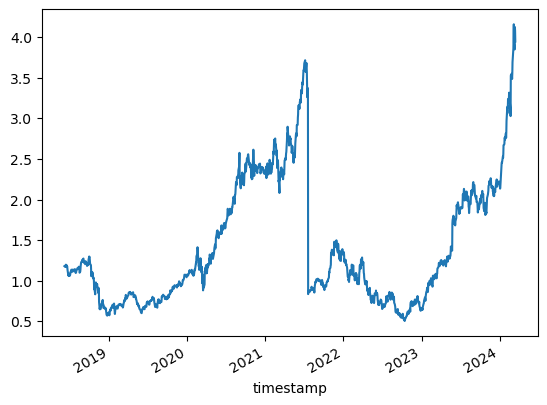

In [50]:
df['Cumulative Returns'].plot()
# can delete this plot, I was just curious

In [51]:
# feature engineering

# can reset these windows based on strategy
short_window = 5
long_window = 100

df['SMA_Fast'] = df['NVDA close'].rolling(window=short_window).mean()
df['SMA_Slow'] = df['NVDA close'].rolling(window=long_window).mean()

df = df.dropna()
df


# later on -> trial different training windows using DateOffset()

,NVDA close,Daily Returns,Cumulative Returns,SMA_Fast,SMA_Slow
timestamp,,,,,
2018-10-26,198.29,-0.045949,0.890155,211.564,256.4185
2018-10-29,185.62,-0.063896,0.833277,202.444,255.6457
2018-10-30,203.00,0.093632,0.911299,198.832,255.0529
2018-10-31,210.83,0.038571,0.946449,201.116,254.5550
2018-11-01,218.11,0.034530,0.979130,203.170,254.1103
...,...,...,...,...,...
2024-03-08,875.28,-0.055477,3.929269,880.196,562.1301
2024-03-11,857.74,-0.020039,3.850529,881.270,566.0980
2024-03-12,919.13,0.071572,4.126118,893.168,570.8955


In [52]:
# Initialize Signals based on strategy (i.e. DMAC, buy and hold, etc) 

In [53]:
df['Daily Returns Lagged'] = df['Daily Returns'].shift(-1)
df

,NVDA close,Daily Returns,Cumulative Returns,SMA_Fast,SMA_Slow,Daily Returns Lagged
timestamp,,,,,,
2018-10-26,198.29,-0.045949,0.890155,211.564,256.4185,-0.063896
2018-10-29,185.62,-0.063896,0.833277,202.444,255.6457,0.093632
2018-10-30,203.00,0.093632,0.911299,198.832,255.0529,0.038571
2018-10-31,210.83,0.038571,0.946449,201.116,254.5550,0.034530
2018-11-01,218.11,0.034530,0.979130,203.170,254.1103,-0.014626
...,...,...,...,...,...,...
2024-03-08,875.28,-0.055477,3.929269,880.196,562.1301,-0.020039
2024-03-11,857.74,-0.020039,3.850529,881.270,566.0980,0.071572
2024-03-12,919.13,0.071572,4.126118,893.168,570.8955,-0.011152


In [55]:
df[['Daily Returns Lagged', 'Daily Returns']].corr()

# maybe not to use lagged strategy 
# consider DMAC? 

,Daily Returns Lagged,Daily Returns
Daily Returns Lagged,1.000000,-0.078563
Daily Returns,-0.078563,1.000000


In [ ]:
# From Algo Trading 3 live 

# Submit order
api.submit_order(
    symbol="META", 
    qty=number_of_shares, 
    side=orderSide, 
    time_in_force="gtc", 
    type="limit", 
    limit_price=limit_amount
